## HW 4 - Naive Bayes
Submitted by: Trixelle Johanna Juan Tong

In [3]:
# import statements
import numpy as np
import pandas as pd
import zipfile
import email
import re  # for cleaning the email content
from collections import Counter  # for getting unique words
import matplotlib.pyplot as plt

# for evaluation
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

## Preprocessing the data

We will first clean the email contents and remove the words from the document which may not contribute to the information we want to extract which includes:
- alphanumeric characters
- punctuation marks
- stop words

We will also be splitting the dataset into 3 groups:
- training set for ham
- training set for spam
- test set

We will also extract a list of unique words from the training set with its summed number of occurrences from the spam and ham set up to the 10000th most common word.

##### Step 1: Looping through label text file for ham or spam
We're gonna make a dictionary with a the email file location as the key and the label as value

We will also convert the label for spam and ham where:
- 1 is for spam
- 0 is for ham

In [5]:
# make a dictionary to store the file path and label
labels_dict = {'file_path':[], 'label':[]}

# read the file for labels 
with open("trec06/trec06p-cs280/labels") as f:
    for line in f:
        # val is either ham or spam
        # key is the file path location of the email
        val, key = line.split()
        if val == 'ham':
            # set label of ham to 0
            labels_dict['file_path'].append(key.replace("../data/",""))
            labels_dict['label'].append(0)
        elif val == 'spam':
            # set label of spam to 1
            labels_dict['file_path'].append(key.replace("../data/",""))
            labels_dict['label'].append(1)

# convert dictionary to dataframe
df_labels = pd.DataFrame.from_dict(labels_dict)
df_labels

,file_path,label
0,000/000,0
1,000/001,1
2,000/002,1
3,000/003,0
4,000/004,1
...,...,...
37817,126/017,1
37818,126/018,1
37819,126/019,1
37820,126/020,1


##### Step 2: Get stop words from txt file
Store the stop words into a list

In [6]:
# store all the stop words into a list
with open("stop_words.txt","r") as f:
    stop_words = f.read().splitlines()
stop_words

['a',
 'able',
 'about',
 'above',
 'abst',
 'accordance',
 'according',
 'accordingly',
 'across',
 'act',
 'actually',
 'added',
 'adj',
 'adopted',
 'affected',
 'affecting',
 'affects',
 'after',
 'afterwards',
 'again',
 'against',
 'ah',
 'all',
 'almost',
 'alone',
 'along',
 'already',
 'also',
 'although',
 'always',
 'am',
 'among',
 'amongst',
 'an',
 'and',
 'announce',
 'another',
 'any',
 'anybody',
 'anyhow',
 'anymore',
 'anyone',
 'anything',
 'anyway',
 'anyways',
 'anywhere',
 'apparently',
 'approximately',
 'are',
 'aren',
 'arent',
 'arise',
 'around',
 'as',
 'aside',
 'ask',
 'asking',
 'at',
 'auth',
 'available',
 'away',
 'awfully',
 'b',
 'back',
 'be',
 'became',
 'because',
 'become',
 'becomes',
 'becoming',
 'been',
 'before',
 'beforehand',
 'begin',
 'beginning',
 'beginnings',
 'begins',
 'behind',
 'being',
 'believe',
 'below',
 'beside',
 'besides',
 'between',
 'beyond',
 'biol',
 'both',
 'brief',
 'briefly',
 'but',
 'by',
 'c',
 'ca',
 'came',


###### Step 3: Cleaning the email contents

We will create a function to execute the cleaning process of the email content which would remove alphanumeric characters, punctuations, and the stop words which will then return the cleaned message

In [7]:
# function to clean message from alphanumeric characters, punctuations, and stop words
def clean_msg(message):
    w = []   # store the cleaned words
    for word in message.split():
        temp = re.sub('<[^<>]+>','', word)
        #temp = re.sub('<.*?>','', word)  # remove html tags
        temp = re.sub('[^a-z]','', temp)  # remove special characters and digits
        #temp = re.sub('\W+','', temp)  # remove special characters
        #temp = re.sub('\d+', '', temp) # remove digits
        if temp != "" and temp not in stop_words: # add to list if word isn't in stop_words and empty 
            w.append(temp)

    cleaned_message = " ".join(w)  # change message to a string format
    return cleaned_message         # return cleaned email message

In [8]:
# make a dictionary to store the file path and its corresponding cleaned email content
content_dict = {'file_path':[], 'Content':[]}

# loop through the file paths 
for path in df_labels['file_path']:
    
    # append file path to content_dict
    content_dict['file_path'].append(path)
    
    # open file for the email content 
    # default encoding is set to ISO-8859-1
    with open(f"trec06/trec06p-cs280/data/{path}", "r", encoding="ISO-8859-1") as f:
        msg = ""   # to store the email message 
        message = email.message_from_file(f)  # message object

        # checks if email is multipart
        if message.is_multipart():
            # go through the parts of the email
            for payload in message.walk():
                # checks whether the current part is text/plain
                if payload.get_content_type() == "text/plain": 
                    msg = payload.get_payload().lower()  # get the message and set to lowercase
                    break
        # get message if not multipart
        else:
            msg = message.get_payload().lower()
        
        # clean the email message
        cleaned_message = clean_msg(msg)
        
        # append the cleaned message to the content_dict under content 
        content_dict['Content'].append(cleaned_message)

In [9]:
# convert dictionary to dataframe
# shows the email content and its corresponding file path
df_content = pd.DataFrame.from_dict(content_dict)
df_content

,file_path,Content
0,000/000,mailing list queried weeks ago running set arc...
1,000/001,luxury watches buy rolex rolex cartier bvlgari...
2,000/002,academic qualifications prestigious nonacc red...
3,000/003,greetings verify subscription planfans list ch...
4,000/004,chauncey conferred luscious continued tonsillitis
...,...,...
37817,126/017,great news expec ted infinex ventures infx pri...
37818,126/018,oil sector going crazy weekly gift kkpt thing ...
37819,126/019,httpvdtobjdocscaninfo suffering pain depressio...
37820,126/020,prosperous future increased money earning powe...


##### Merging df_label and df_content
We will be merging the dataframes that contains the label whether an email is a spam or a ham, and the email content 

In [10]:
# merge df_labels and df_content to contain into one dataframe
# merge both dataframes on the file_path column
df_merged = pd.merge(df_labels, df_content, on='file_path')
df_merged

,file_path,label,Content
0,000/000,0,mailing list queried weeks ago running set arc...
1,000/001,1,luxury watches buy rolex rolex cartier bvlgari...
2,000/002,1,academic qualifications prestigious nonacc red...
3,000/003,0,greetings verify subscription planfans list ch...
4,000/004,1,chauncey conferred luscious continued tonsillitis
...,...,...,...
37817,126/017,1,great news expec ted infinex ventures infx pri...
37818,126/018,1,oil sector going crazy weekly gift kkpt thing ...
37819,126/019,1,httpvdtobjdocscaninfo suffering pain depressio...
37820,126/020,1,prosperous future increased money earning powe...


##### Step 4: Splitting the dataset

The training set will be from folders 000-070 and test set from folders 071-126

In [11]:
# train set - folders 000-070
# test set - folders 071-126

# general train set
df_train = df_merged[df_merged['file_path'] < '071']

# for train set of spam
df_train_spam = df_train[df_train['label'] == 1]
df_train_spam = df_train_spam.reset_index()
print("Spam training set")
display(df_train_spam)

# for train set of ham
df_train_ham = df_train[df_train['label'] == 0]
df_train_ham = df_train_ham.reset_index()
print("Ham training set")
display(df_train_ham)

# test set
df_test = df_merged[df_merged['file_path'] >= '071']
print("Testing set")
display(df_test)

Spam training set


,index,file_path,label,Content
0,1,000/001,1,luxury watches buy rolex rolex cartier bvlgari...
1,2,000/002,1,academic qualifications prestigious nonacc red...
2,4,000/004,1,chauncey conferred luscious continued tonsillitis
3,7,000/007,1,nbc today body diet beaches magazines hollywoo...
4,8,000/008,1,oil sector going crazy weekly gift kkpt thing ...
...,...,...,...,...
13772,21294,070/294,1,txtadd
13773,21295,070/295,1,btijclnab binpqnejgmb httpgethighbizez bldb xi...
13774,21296,070/296,1,special offer adobe video collection adobe pre...
13775,21297,070/297,1,doctype html public wcdtd html transitionalen ...


Ham training set


,index,file_path,label,Content
0,0,000/000,0,mailing list queried weeks ago running set arc...
1,3,000/003,0,greetings verify subscription planfans list ch...
2,5,000/005,0,quiet quiet well straw poll plan running
3,6,000/006,0,working departed totally bell labs recommended...
4,10,000/010,0,greetings mass acknowledgement signed planfans...
...,...,...,...,...
7518,21270,070/270,0,equation generate prime numbers equation theor...
7519,21271,070/271,0,equation generate prime numbers equation theor...
7520,21288,070/288,0,dear dmdx users guidance generating dmdx item ...
7521,21293,070/293,0,built handyboard works great testmotor passes ...


Testing set


,file_path,label,Content
21300,071/000,1,hesitantly derive perverse satisfaction clodho...
21301,071/001,0,things perform experiment display will remain ...
21302,071/002,1,best offer month viggra ci ialis vaiium xa naa...
21303,071/003,1,de ar wne cr doesnt matter ow real st mmed ia ...
21304,071/004,1,special offer adobe video collection adobe pre...
...,...,...,...
37817,126/017,1,great news expec ted infinex ventures infx pri...
37818,126/018,1,oil sector going crazy weekly gift kkpt thing ...
37819,126/019,1,httpvdtobjdocscaninfo suffering pain depressio...
37820,126/020,1,prosperous future increased money earning powe...


##### Step 5: Extracting the first 10000 most common words from the training set

In [12]:
# use the Counter class from Collections library to get the most common words
words_top_10k = Counter(" ".join(df_train['Content']).split()).most_common(10000)
df_top_10k_words = pd.DataFrame(words_top_10k, columns=['Word', 'Frequency'])
df_top_10k_words

,Word,Frequency
0,bb,16792
1,td,11367
2,will,11325
3,width,7766
4,board,5171
...,...,...
9995,ruby,20
9996,wavelength,20
9997,cg,20
9998,recomb,20


## Creating the feature matrices

In [13]:
# create ham and spam feature dictionaries initially with their corresponding length
ham_word_counts = {unique_word: [0] * len(df_train_ham) for unique_word, _ in words_top_10k}
spam_word_counts = {unique_word: [0] * len(df_train_spam) for unique_word, _ in words_top_10k}

# create them as dataframes 
df_ham_word_counts = pd.DataFrame(ham_word_counts)
df_spam_word_counts = pd.DataFrame(spam_word_counts)

# convert the top 10k words into a list
words_top_10k_list = [key for key, _ in words_top_10k]

In [14]:
# for ham 

# iterate through the rows of the train ham set
for i in df_train_ham.index:
        # count the word frequency per row in the train ham set
        word_freq = dict(Counter(df_train_ham['Content'][i].split()))
        for key, val in word_freq.items():
            if key in words_top_10k_list:    # add the word frequency to the row and column where the word is found
                df_ham_word_counts.loc[i, key] += val

# convert to an numpy array for feature matrix
ham_feature_matrix = df_ham_word_counts.to_numpy()
ham_feature_matrix

array([[0, 0, 2, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 1, ..., 0, 0, 0],
       [0, 0, 2, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int64)

In [15]:
# for spam

# iterate through the rows of the train spam set
for i in df_train_spam.index:
        # count the word frequency per row in the train ham set
        word_freq = dict(Counter(df_train_spam['Content'][i].split()))
        for key, val in word_freq.items():
            if key in words_top_10k_list:  # add the word frequency to the row and column where the word is found
                df_spam_word_counts.loc[i, key] += val

# convert to an numpy array for feature matrix
spam_feature_matrix = df_spam_word_counts.to_numpy()
spam_feature_matrix

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int64)

## Computing the Priors

In [16]:
# compute the prior probabilities for spam and ham

n_ham = df_train_ham.shape[0]       # number of ham emails in training set
n_spam = df_train_spam.shape[0]     # number of spam emails in training set
n_doc = df_train.shape[0]           # number of total emails in training set

p_ham = n_ham / n_doc               # divide number of ham emails over the total emails in training set
p_spam = n_spam / n_doc             # divide the number of spam emails over the total emails in training set

print("p_ham: ", p_ham)
print("p_spam: ", p_spam)

p_ham:  0.3531924882629108
p_spam:  0.6468075117370892


## Computing the Likelihood of each word

In [17]:
# gets the sum of each word in ham class
ham_word_count = np.sum(ham_feature_matrix, axis=0)

# gets the sum of each word in spam class
spam_word_count = np.sum(spam_feature_matrix, axis=0)

# get total word in ham class
ham_word_total = np.sum(ham_word_count)

# get total word in spam class
spam_word_total = np.sum(spam_word_count)

# list to contain the probabilities of each word given that it is at ham or spam class
p_count_ham = {}
p_count_spam = {}

# for laplace smoothing
a = 1

for i in range(len(words_top_10k_list)):
    # P(w_i|ham) = count(w_i,ham) + a / summation of count(w_i,ham) + a*V 
    # count of certain word in ham class over the total words in ham class
    # where V is the unique words of the document aka the top 10000 words
    # same formula is used for spam
    temp_ham = (ham_word_count[i]+a) / (ham_word_total + a*len(words_top_10k_list))
    temp_spam = (spam_word_count[i]+a) / (spam_word_total + a*len(words_top_10k_list))
    p_count_ham[words_top_10k_list[i]] = temp_ham
    p_count_spam[words_top_10k_list[i]] = temp_spam

## Classifying the emails

In [18]:
# function to classify the emails
# used log function to calculate whether email is spam or ham
def classify_emails(email, p_ham, p_spam, p_count_ham, p_count_spam, word_list):
    # initialize the log values of ham and spam with the log of their probabilities
    log_p_ham = np.log(p_ham)
    log_p_spam = np.log(p_spam)
    
    # split the email content for it to be tokenized
    words = str(email).split()
    
    for w in words:
        # add the probability value if the word is at the word list aka the top 10k most common words 
        if w in word_list:
            log_p_ham += np.log(p_count_ham[w])
            log_p_spam += np.log(p_count_spam[w])
    
    # return 0 if the value of ham is greater than spam 
    if log_p_ham > log_p_spam:
        return 0
    # return 1 if value of spam is greater than ham
    else:
        return 1

## Testing the Classifer

In [19]:
# create a dictionary to store file path and the predicted label which we will use in merging with the df of test set
predicted_test = {'file_path':[], 'predicted_label':[]}

# loop through the email content of the test set and file path
for file_path, msg in zip(df_test['file_path'], df_test['Content']):
    predicted_test['file_path'].append(file_path)   # add the file path
    classify = classify_emails(msg, p_ham, p_spam, p_count_ham, p_count_spam, words_top_10k_list)  # classify the current content whether it's spam or ham
    predicted_test['predicted_label'].append(classify)  # append either 1 or 0 as the predicted label

In [20]:
# convert dictionary to dataframe
df_test_predicted = pd.DataFrame.from_dict(predicted_test)
df_test_predicted

,file_path,predicted_label
0,071/000,1
1,071/001,0
2,071/002,1
3,071/003,1
4,071/004,1
...,...,...
16517,126/017,1
16518,126/018,1
16519,126/019,1
16520,126/020,1


In [21]:
# merge both dataframes on the file_path column
# we will use the label and predicted_label columns for evaluating the performance later on
df_test_merged = pd.merge(df_test, df_test_predicted, on='file_path')
df_test_merged

,file_path,label,Content,predicted_label
0,071/000,1,hesitantly derive perverse satisfaction clodho...,1
1,071/001,0,things perform experiment display will remain ...,0
2,071/002,1,best offer month viggra ci ialis vaiium xa naa...,1
3,071/003,1,de ar wne cr doesnt matter ow real st mmed ia ...,1
4,071/004,1,special offer adobe video collection adobe pre...,1
...,...,...,...,...
16517,126/017,1,great news expec ted infinex ventures infx pri...,1
16518,126/018,1,oil sector going crazy weekly gift kkpt thing ...,1
16519,126/019,1,httpvdtobjdocscaninfo suffering pain depressio...,1
16520,126/020,1,prosperous future increased money earning powe...,1


## Performance Evaluation
We will evaluate the performance by: 
- Accuracy
- Recall
- Precision
- F1 Score

In [22]:
# performance evaluation of the test set
print("Test Set Accuracy Score:", accuracy_score(df_test_merged['label'].to_numpy(), df_test_merged['predicted_label'].to_numpy()))
print("Test Set Recall Score:", recall_score(df_test_merged['label'].to_numpy(), df_test_merged['predicted_label'].to_numpy()))
print("Test Set Precision Score:", precision_score(df_test_merged['label'].to_numpy(), df_test_merged['predicted_label'].to_numpy()))
print("Test Set F1 Score:", f1_score(df_test_merged['label'].to_numpy(), df_test_merged['predicted_label'].to_numpy()))

Test Set Accuracy Score: 0.9227696404793608
Test Set Recall Score: 0.9075886843286933
Test Set Precision Score: 0.9761421810103351
Test Set F1 Score: 0.9406180193596426


## Results and Discussion

#### Q1: What is the effect of removing stop words in terms of precision, recall, and accuracy? Show a plot or a table of these results.

We will create a separate uncleaned dataframe which includes the stop words

The process done here is similar to what's been done previously but the only difference is the inclusion of the stop words in the content

In [23]:
# make a dictionary to store the file path and its corresponding cleaned email content
uncleaned_content_dict = {'file_path':[], 'Content':[]}

# loop through the file paths 
for path in df_labels['file_path']:
    
    # append file path to content_dict
    uncleaned_content_dict['file_path'].append(path)
    
    # open file for the email content 
    # default encoding is set to ISO-8859-1
    with open(f"trec06/trec06p-cs280/data/{path}", "r", encoding="ISO-8859-1") as f:
        msg = ""   # to store the email message 
        message = email.message_from_file(f)  # message object

        # checks if email is multipart
        if message.is_multipart():
            # go through the parts of the email
            for payload in message.walk():
                # checks whether the current part is text/plain
                if payload.get_content_type() == "text/plain": 
                    msg = payload.get_payload().lower()  # get the message and set to lowercase
                    break
        # get message if not multipart
        else:
            msg = message.get_payload().lower()
        
        w = []   # store the cleaned words
        for word in msg.split():
            temp = re.sub('<.*?>','', word)  # remove html tags
            temp = re.sub('\W+','', temp)  # remove special characters
            temp = re.sub('\d+', '', temp) # remove digits
            w.append(temp)

        cleaned_message = " ".join(w)     
        
        # append the cleaned message to the content_dict under content 
        uncleaned_content_dict['Content'].append(cleaned_message)


In [24]:
# df that contains the email content w/o removing stop words
df_uncleaned_content = pd.DataFrame.from_dict(uncleaned_content_dict)
df_merged_uncleaned = pd.merge(df_labels, df_uncleaned_content, on='file_path')
df_merged_uncleaned

,file_path,label,Content
0,000/000,0,the mailing list i queried about a few weeks a...
1,000/001,1,luxury watches buy your own rolex for only r...
2,000/002,1,academic qualifications available from prestig...
3,000/003,0,greetings all this is to verify your subscript...
4,000/004,1,try chauncey may conferred the luscious not co...
...,...,...,...
37817,126/017,1,great news expec ted infinex ventures inc infx...
37818,126/018,1,the oil sector is going crazy this is our week...
37819,126/019,1,httpvdtobjdocscaninfo suffering from pain depr...
37820,126/020,1,u n i v e r s i t y d i p l o m a s do you wan...


In [25]:
# general train set
df_train_uncleaned = df_merged_uncleaned[df_merged_uncleaned['file_path'] < '071']

# for train set of spam
df_train_spam_uncleaned = df_train_uncleaned[df_train_uncleaned['label'] == 1]
df_train_spam_uncleaned = df_train_spam_uncleaned.reset_index()
print("Spam training set with stopwords")
display(df_train_spam_uncleaned)

# for train set of ham
df_train_ham_uncleaned = df_train_uncleaned[df_train_uncleaned['label'] == 0]
df_train_ham_uncleaned = df_train_ham_uncleaned.reset_index()
print("Ham training set with stopwords")
display(df_train_ham_uncleaned)

# test set
df_test_uncleaned = df_merged_uncleaned[df_merged_uncleaned['file_path'] >= '071']
print("Testing set with stopwords")
display(df_test_uncleaned)

Spam training set with stopwords


,index,file_path,label,Content
0,1,000/001,1,luxury watches buy your own rolex for only r...
1,2,000/002,1,academic qualifications available from prestig...
2,4,000/004,1,try chauncey may conferred the luscious not co...
3,7,000/007,1,from nbc today show its the look everyone want...
4,8,000/008,1,the oil sector is going crazy this is our week...
...,...,...,...,...
13772,21294,070/294,1,txt_add
13773,21295,070/295,1,btijclnab binpqnejgmb httpgethighbizez bldb xi...
13774,21296,070/296,1,special offer adobe video collection adobe pre...
13775,21297,070/297,1,doctype html public wcdtd html transitionalen...


Ham training set with stopwords


,index,file_path,label,Content
0,0,000/000,0,the mailing list i queried about a few weeks a...
1,3,000/003,0,greetings all this is to verify your subscript...
2,5,000/005,0,its quiet too quiet well how about a straw pol...
3,6,000/006,0,its working here i have departed almost totall...
4,10,000/010,0,greetings all this is a mass acknowledgement t...
...,...,...,...,...
7518,21270,070/270,0,here is an equation that generate all prime nu...
7519,21271,070/271,0,here is an equation that generate all prime nu...
7520,21288,070/288,0,dear dmdx users i would like guidance in gener...
7521,21293,070/293,0,hi i built up a handyboard and most of it work...


Testing set with stopwords


,file_path,label,Content
21300,071/000,1,where we can hesitantly derive perverse satisf...
21301,071/001,0,there are several things you can use to perfor...
21302,071/002,1,best offer of the month viggra ci ialis va...
21303,071/003,1,de i ar home o h wne n r your cr v ed b it d...
21304,071/004,1,special offer adobe video collection adobe pre...
...,...,...,...
37817,126/017,1,great news expec ted infinex ventures inc infx...
37818,126/018,1,the oil sector is going crazy this is our week...
37819,126/019,1,httpvdtobjdocscaninfo suffering from pain depr...
37820,126/020,1,u n i v e r s i t y d i p l o m a s do you wan...


In [26]:
# top 10000 words including stop words
words_top_10k_uncleaned = Counter(" ".join(df_train_uncleaned['Content']).split()).most_common(10000)
df_top_10k_words_uncleaned = pd.DataFrame(words_top_10k_uncleaned, columns=['Word', 'Frequency'])
df_top_10k_words_uncleaned

,Word,Frequency
0,the,130073
1,to,80642
2,a,69950
3,and,62161
4,of,56636
...,...,...
9995,ôàêòîðîâ,24
9996,sil,24
9997,s³üûëhttpcustominfowphpi,24
9998,veen,24


In [27]:
# create ham and spam word counts
ham_word_counts_uncleaned = {unique_word: [0] * len(df_train_ham_uncleaned) for unique_word, _ in words_top_10k_uncleaned}
spam_word_counts_uncleaned = {unique_word: [0] * len(df_train_spam_uncleaned) for unique_word, _ in words_top_10k_uncleaned}

df_ham_word_counts_uncleaned = pd.DataFrame(ham_word_counts_uncleaned)
df_spam_word_counts_uncleaned = pd.DataFrame(spam_word_counts_uncleaned)

words_top_10k_list_uncleaned = [key for key, _ in words_top_10k_uncleaned]

In [28]:
# for ham 
for i in df_train_ham_uncleaned.index:
        word_freq = dict(Counter(df_train_ham_uncleaned['Content'][i].split()))
        for key, val in word_freq.items():
            if key in words_top_10k_list_uncleaned:
                df_ham_word_counts_uncleaned.loc[i, key] += val

ham_feature_matrix_uncleaned = df_ham_word_counts_uncleaned.to_numpy()
ham_feature_matrix_uncleaned

array([[26, 18, 11, ...,  0,  0,  0],
       [ 4,  4,  1, ...,  0,  0,  0],
       [ 0,  0,  1, ...,  0,  0,  0],
       ...,
       [21,  6, 12, ...,  0,  0,  0],
       [ 6,  5,  9, ...,  0,  0,  0],
       [10,  4,  1, ...,  0,  0,  0]], dtype=int64)

In [29]:
# for spam
for i in df_train_spam_uncleaned.index:
        word_freq = dict(Counter(df_train_spam_uncleaned['Content'][i].split()))
        for key, val in word_freq.items():
            if key in words_top_10k_list_uncleaned:
                df_spam_word_counts_uncleaned.loc[i, key] += val

spam_feature_matrix_uncleaned = df_spam_word_counts_uncleaned.to_numpy()
spam_feature_matrix_uncleaned

array([[2, 0, 1, ..., 0, 0, 0],
       [6, 1, 2, ..., 0, 0, 0],
       [1, 0, 1, ..., 0, 0, 0],
       ...,
       [0, 3, 0, ..., 0, 0, 0],
       [0, 0, 4, ..., 0, 0, 0],
       [1, 1, 0, ..., 0, 0, 0]], dtype=int64)

In [30]:
# gets the sum of each word in ham class
ham_word_count_uncleaned = np.sum(ham_feature_matrix_uncleaned, axis=0)

# gets the sum of each word in spam class
spam_word_count_uncleaned = np.sum(spam_feature_matrix_uncleaned, axis=0)

# get total word in ham class
ham_word_total_uncleaned = np.sum(ham_word_count_uncleaned)

# get total word in spam class
spam_word_total_uncleaned = np.sum(spam_word_count_uncleaned)

# list to contain the probabilities of each word given that it is at ham or spam class
p_count_ham_uncleaned = {}
p_count_spam_uncleaned = {}

# for laplace smoothing
a = 1

for i in range(len(words_top_10k_list_uncleaned)):
    # P(w_i|ham) = count(w_i,ham) + a / summation of count(w_i,ham) + a*V 
    # count of certain word in ham class over the total words in ham class
    # where V is the unique words of the document aka the top 10000 words
    # same formula is used for spam
    temp_ham = (ham_word_count_uncleaned[i]+a) / (ham_word_total_uncleaned + a*len(words_top_10k_list_uncleaned))
    temp_spam = (spam_word_count_uncleaned[i]+a) / (spam_word_total_uncleaned + a*len(words_top_10k_list_uncleaned))
    p_count_ham_uncleaned[words_top_10k_list_uncleaned[i]] = temp_ham
    p_count_spam_uncleaned[words_top_10k_list_uncleaned[i]] = temp_spam

In [31]:
# for the predicted labels using top 10k words including stop words
predicted_test_uncleaned = {'file_path':[], 'predicted_label':[]}

for file_path, msg in zip(df_test['file_path'], df_test['Content']):
    predicted_test_uncleaned['file_path'].append(file_path)
    classify = classify_emails(msg, p_ham, p_spam, p_count_ham_uncleaned, p_count_spam_uncleaned, words_top_10k_list_uncleaned)
    predicted_test_uncleaned['predicted_label'].append(classify)

In [32]:
df_test_predicted_uncleaned = pd.DataFrame.from_dict(predicted_test_uncleaned)
df_test_predicted_uncleaned

,file_path,predicted_label
0,071/000,1
1,071/001,0
2,071/002,1
3,071/003,1
4,071/004,1
...,...,...
16517,126/017,1
16518,126/018,1
16519,126/019,1
16520,126/020,1


In [33]:
# merge both dataframes on the file_path column
df_test_merged_uncleaned = pd.merge(df_test_uncleaned, df_test_predicted_uncleaned, on='file_path')
df_test_merged_uncleaned

,file_path,label,Content,predicted_label
0,071/000,1,where we can hesitantly derive perverse satisf...,1
1,071/001,0,there are several things you can use to perfor...,0
2,071/002,1,best offer of the month viggra ci ialis va...,1
3,071/003,1,de i ar home o h wne n r your cr v ed b it d...,1
4,071/004,1,special offer adobe video collection adobe pre...,1
...,...,...,...,...
16517,126/017,1,great news expec ted infinex ventures inc infx...,1
16518,126/018,1,the oil sector is going crazy this is our week...,1
16519,126/019,1,httpvdtobjdocscaninfo suffering from pain depr...,1
16520,126/020,1,u n i v e r s i t y d i p l o m a s do you wan...,1


In [34]:
print("Test Set with stopwords Accuracy Score:", accuracy_score(df_test_merged_uncleaned['label'].to_numpy(), df_test_merged_uncleaned['predicted_label'].to_numpy()))
print("Test Set with stopwords Recall Score:", recall_score(df_test_merged_uncleaned['label'].to_numpy(), df_test_merged_uncleaned['predicted_label'].to_numpy()))
print("Test Set with stopwords Precision Score:", precision_score(df_test_merged_uncleaned['label'].to_numpy(), df_test_merged_uncleaned['predicted_label'].to_numpy()))
print("Test Set with stopwords F1 Score:", f1_score(df_test_merged_uncleaned['label'].to_numpy(), df_test_merged_uncleaned['predicted_label'].to_numpy()))

Test Set with stopwords Accuracy Score: 0.9295484808134609
Test Set with stopwords Recall Score: 0.9220475976650202
Test Set with stopwords Precision Score: 0.9719776578623497
Test Set with stopwords F1 Score: 0.9463545027191446


In [35]:
print("Test Set Accuracy Score:", accuracy_score(df_test_merged['label'].to_numpy(), df_test_merged['predicted_label'].to_numpy()))
print("Test Set Recall Score:", recall_score(df_test_merged['label'].to_numpy(), df_test_merged['predicted_label'].to_numpy()))
print("Test Set Precision Score:", precision_score(df_test_merged['label'].to_numpy(), df_test_merged['predicted_label'].to_numpy()))
print("Test Set F1 Score:", f1_score(df_test_merged['label'].to_numpy(), df_test_merged['predicted_label'].to_numpy()))

Test Set Accuracy Score: 0.9227696404793608
Test Set Recall Score: 0.9075886843286933
Test Set Precision Score: 0.9761421810103351
Test Set F1 Score: 0.9406180193596426


In [36]:
# metrics of test set w/ stop words
accuracy_score_uncleaned = accuracy_score(df_test_merged_uncleaned['label'].to_numpy(), df_test_merged_uncleaned['predicted_label'].to_numpy())
recall_score_uncleaned = recall_score(df_test_merged_uncleaned['label'].to_numpy(), df_test_merged_uncleaned['predicted_label'].to_numpy())
precision_score_uncleaned = precision_score(df_test_merged_uncleaned['label'].to_numpy(), df_test_merged_uncleaned['predicted_label'].to_numpy())
f1_score_uncleaned = f1_score(df_test_merged_uncleaned['label'].to_numpy(), df_test_merged_uncleaned['predicted_label'].to_numpy())
uncleaned = {'accuracy': accuracy_score_uncleaned, 'recall': recall_score_uncleaned, 'precision': precision_score_uncleaned, 'f1_score': f1_score_uncleaned}

# metrics of test set w/o stop words
accuracy_score_100 = accuracy_score(df_test_merged['label'].to_numpy(), df_test_merged['predicted_label'].to_numpy())
recall_score_100 = recall_score(df_test_merged['label'].to_numpy(), df_test_merged['predicted_label'].to_numpy())
precision_score_100 = precision_score(df_test_merged['label'].to_numpy(), df_test_merged['predicted_label'].to_numpy())
f1_score_100 = f1_score(df_test_merged['label'].to_numpy(), df_test_merged['predicted_label'].to_numpy())
cleaned = {'accuracy': accuracy_score_100, 'recall': recall_score_100, 'precision': precision_score_100, 'f1_score': f1_score_100}

# df for k=50 and k=100 in terms of metrics
df_stop_words = pd.DataFrame([uncleaned,cleaned], index=['with stopwords', 'without stopwords'])
df_stop_words

,accuracy,recall,precision,f1_score
with stopwords,0.929548,0.922048,0.971978,0.946355
without stopwords,0.922770,0.907589,0.976142,0.940618


In [90]:
print("Confusion Matrix without stopwords")
print(confusion_matrix(df_test_merged['label'].to_numpy(), df_test_merged['predicted_label'].to_numpy(), labels=[1, 0]))
print("\nConfusion Matrix with stopwords")
print(confusion_matrix(df_test_merged_uncleaned['label'].to_numpy(), df_test_merged_uncleaned['predicted_label'].to_numpy(), labels=[1, 0]))

Confusion Matrix without stopwords
[[10106  1029]
 [  247  5140]]

Confusion Matrix with stopwords
[[10267   868]
 [  296  5091]]


The accuracy, recall, and f1 scores of classifying with stop words are slightly greater than classifying without stop words. We can infer that including stop words may improve the accuracy of classifying whether the email is a spam or ham. 

Based on the confusion matrix, the True negative classification with stopwords decreased compared to that of not including stopwords in the word list. This may be a problem once we would like to keep non-spam messages out of spam messages in classifying.

#### Q2: Experiment on the number of words used for training to include words occurring 50 and 100 times

##### For k = 50 
We will only include words that occur at least 50 times into the word list

In [37]:
content_dict2 = dict(Counter(" ".join(df_train['Content']).split()))

content_dict_50 = {}
for key,val in content_dict2.items():
    if val >= 50:  # only include words that occur at least 50 times
        content_dict_50[key] = val

# create a list from the dictionary
content_list_50 = [key for key, _ in content_dict_50.items()]
content_dict_50

{'mailing': 625,
 'list': 3950,
 'weeks': 569,
 'ago': 662,
 'running': 952,
 'set': 1587,
 'archive': 183,
 'server': 561,
 'official': 189,
 'message': 3614,
 'moment': 189,
 'joe': 158,
 'people': 1846,
 'desire': 246,
 'serious': 116,
 'discussion': 607,
 'roman': 351,
 'assume': 206,
 'will': 11325,
 'provided': 297,
 'operate': 199,
 'guidelines': 80,
 'interests': 52,
 'going': 1185,
 'limit': 170,
 'sort': 312,
 'groups': 329,
 'years': 1405,
 'primary': 114,
 'observations': 126,
 'net': 236,
 'well': 2650,
 'hope': 840,
 'help': 3801,
 'problem': 2361,
 'extent': 54,
 'resource': 341,
 'policy': 215,
 'subject': 3568,
 'constitution': 50,
 'dont': 3574,
 'rules': 105,
 'things': 1159,
 'appropriate': 279,
 'call': 1737,
 'simple': 637,
 'follow': 308,
 'teaching': 247,
 'reflect': 65,
 'thinking': 273,
 'places': 164,
 'doubt': 125,
 'subscribe': 111,
 'interest': 597,
 'interesting': 466,
 'doesnt': 1097,
 'unix': 405,
 'software': 1428,
 'guys': 215,
 'planning': 191,
 'set

In [38]:
# create ham and spam word counts
ham_word_counts_50 = {unique_word: [0] * len(df_train_ham) for unique_word in content_list_50}
spam_word_counts_50 = {unique_word: [0] * len(df_train_spam) for unique_word in content_list_50}

df_ham_word_counts_50 = pd.DataFrame(ham_word_counts_50)
df_spam_word_counts_50 = pd.DataFrame(spam_word_counts_50)

In [39]:
# for ham 
for i in df_train_ham.index:
        word_freq = dict(Counter(df_train_ham['Content'][i].split()))
        for key, val in word_freq.items():
            if key in content_list_50:
                df_ham_word_counts_50.loc[i, key] += val

ham_feature_matrix_50 = df_ham_word_counts_50.to_numpy()
ham_feature_matrix_50

array([[3, 7, 1, ..., 0, 0, 0],
       [0, 2, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int64)

In [40]:
# for spam
for i in df_train_spam.index:
        word_freq = dict(Counter(df_train_spam['Content'][i].split()))
        for key, val in word_freq.items():
            if key in content_list_50:
                df_spam_word_counts_50.loc[i, key] += val

spam_feature_matrix_50 = df_spam_word_counts_50.to_numpy()
spam_feature_matrix_50

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int64)

In [41]:
# gets the sum of each word in ham class
ham_word_count_50 = np.sum(ham_feature_matrix_50, axis=0)

# gets the sum of each word in spam class
spam_word_count_50 = np.sum(spam_feature_matrix_50, axis=0)

# get total word in ham class
ham_word_total_50 = np.sum(ham_word_count_50)

# get total word in spam class
spam_word_total_50 = np.sum(spam_word_count_50)

# list to contain the probabilities of each word given that it is at ham or spam class
p_count_ham_50 = {}
p_count_spam_50 = {}

# for laplace smoothing
a = 1

for i in range(len(content_list_50)):
    # P(w_i|ham) = count(w_i,ham) + a / summation of count(w_i,ham) + a*V 
    # count of certain word in ham class over the total words in ham class
    # where V is the unique words of the document aka the words that occurred at least 50 times
    # same formula is used for spam
    temp_ham = (ham_word_count_50[i]+a) / (ham_word_total_50 + a*len(content_list_50))
    temp_spam = (spam_word_count_50[i]+a) / (spam_word_total_50 + a*len(content_list_50))
    p_count_ham_50[content_list_50[i]] = temp_ham
    p_count_spam_50[content_list_50[i]] = temp_spam

In [42]:
p_count_ham_50

{'mailing': 0.0008691131166241163,
 'list': 0.005660099172014558,
 'weeks': 0.00038178897623130823,
 'ago': 0.0005695794889304476,
 'running': 0.0014371406178463066,
 'set': 0.0022550381400979302,
 'archive': 0.00028090977519458043,
 'server': 0.0007092583826736092,
 'official': 0.00018623852499088207,
 'message': 0.004828233760388618,
 'moment': 0.00020331038978171293,
 'joe': 0.00023435014394685994,
 'people': 0.0020501757626079603,
 'desire': 0.00010398317645324249,
 'serious': 0.00016295870936702182,
 'discussion': 0.0009420565389122118,
 'roman': 9.622323791195574e-05,
 'assume': 0.0002979816399854113,
 'will': 0.010125167808670956,
 'provided': 0.0003771330131065362,
 'operate': 0.00015830274624224977,
 'guidelines': 9.777522562021308e-05,
 'interests': 7.294342228809548e-05,
 'going': 0.001163990781193013,
 'limit': 0.00024676604561291876,
 'sort': 0.00043610854602031554,
 'groups': 0.00029332567686063925,
 'years': 0.0010056880349507632,
 'primary': 0.00016295870936702182,
 'ob

In [43]:
# the predicted labels that classified the emails using the words that have occurred at least 50 times
predicted_test_50 = {'file_path':[], 'predicted_label':[]}

for file_path, msg in zip(df_test['file_path'], df_test['Content']):
    predicted_test_50['file_path'].append(file_path)
    classify = classify_emails(msg, p_ham, p_spam, p_count_ham_50, p_count_spam_50, content_list_50)
    predicted_test_50['predicted_label'].append(classify)

In [44]:
df_test

,file_path,label,Content
21300,071/000,1,hesitantly derive perverse satisfaction clodho...
21301,071/001,0,things perform experiment display will remain ...
21302,071/002,1,best offer month viggra ci ialis vaiium xa naa...
21303,071/003,1,de ar wne cr doesnt matter ow real st mmed ia ...
21304,071/004,1,special offer adobe video collection adobe pre...
...,...,...,...
37817,126/017,1,great news expec ted infinex ventures infx pri...
37818,126/018,1,oil sector going crazy weekly gift kkpt thing ...
37819,126/019,1,httpvdtobjdocscaninfo suffering pain depressio...
37820,126/020,1,prosperous future increased money earning powe...


In [45]:
df_test_predicted_50 = pd.DataFrame.from_dict(predicted_test_50)
df_test_predicted_50

,file_path,predicted_label
0,071/000,1
1,071/001,0
2,071/002,1
3,071/003,1
4,071/004,1
...,...,...
16517,126/017,1
16518,126/018,1
16519,126/019,1
16520,126/020,1


In [46]:
# merge both dataframes on the file_path column
df_test_merged_50 = pd.merge(df_test, df_test_predicted_50, on='file_path')
df_test_merged_50

,file_path,label,Content,predicted_label
0,071/000,1,hesitantly derive perverse satisfaction clodho...,1
1,071/001,0,things perform experiment display will remain ...,0
2,071/002,1,best offer month viggra ci ialis vaiium xa naa...,1
3,071/003,1,de ar wne cr doesnt matter ow real st mmed ia ...,1
4,071/004,1,special offer adobe video collection adobe pre...,1
...,...,...,...,...
16517,126/017,1,great news expec ted infinex ventures infx pri...,1
16518,126/018,1,oil sector going crazy weekly gift kkpt thing ...,1
16519,126/019,1,httpvdtobjdocscaninfo suffering pain depressio...,1
16520,126/020,1,prosperous future increased money earning powe...,1


In [47]:
print("Test Set with k=50 Accuracy Score:", accuracy_score(df_test_merged_50['label'].to_numpy(), df_test_merged_50['predicted_label'].to_numpy()))
print("Test Set with k=50 Recall Score:", recall_score(df_test_merged_50['label'].to_numpy(), df_test_merged_50['predicted_label'].to_numpy()))
print("Test Set with k=50 Precision Score:", precision_score(df_test_merged_50['label'].to_numpy(), df_test_merged_50['predicted_label'].to_numpy()))
print("Test Set with k=50 F1 Score:", f1_score(df_test_merged_50['label'].to_numpy(), df_test_merged_50['predicted_label'].to_numpy()))

Test Set with k=50 Accuracy Score: 0.923798571601501
Test Set with k=50 Recall Score: 0.9105523125280647
Test Set with k=50 Precision Score: 0.9747164006921746
Test Set with k=50 F1 Score: 0.9415424618099085


##### For k = 100
We will only include words that occur at least 100 times into the word list

The process is also similar to what has been done for k=50

In [48]:
content_dict_100 = {}
for key,val in content_dict2.items():
    if val >= 100:    # only include words that have occurred at least 100 times
        content_dict_100[key] = val

# create a list from the dictionary
content_list_100 = [key for key, _ in content_dict_100.items()]
content_dict_100

{'mailing': 625,
 'list': 3950,
 'weeks': 569,
 'ago': 662,
 'running': 952,
 'set': 1587,
 'archive': 183,
 'server': 561,
 'official': 189,
 'message': 3614,
 'moment': 189,
 'joe': 158,
 'people': 1846,
 'desire': 246,
 'serious': 116,
 'discussion': 607,
 'roman': 351,
 'assume': 206,
 'will': 11325,
 'provided': 297,
 'operate': 199,
 'going': 1185,
 'limit': 170,
 'sort': 312,
 'groups': 329,
 'years': 1405,
 'primary': 114,
 'observations': 126,
 'net': 236,
 'well': 2650,
 'hope': 840,
 'help': 3801,
 'problem': 2361,
 'resource': 341,
 'policy': 215,
 'subject': 3568,
 'dont': 3574,
 'rules': 105,
 'things': 1159,
 'appropriate': 279,
 'call': 1737,
 'simple': 637,
 'follow': 308,
 'teaching': 247,
 'thinking': 273,
 'places': 164,
 'doubt': 125,
 'subscribe': 111,
 'interest': 597,
 'interesting': 466,
 'doesnt': 1097,
 'unix': 405,
 'software': 1428,
 'guys': 215,
 'planning': 191,
 'setting': 322,
 'email': 4058,
 'sources': 202,
 'english': 309,
 'language': 522,
 'magazin

In [49]:
# create ham and spam word counts
ham_word_counts_100 = {unique_word: [0] * len(df_train_ham) for unique_word in content_list_100}
spam_word_counts_100 = {unique_word: [0] * len(df_train_spam) for unique_word in content_list_100}

df_ham_word_counts_100 = pd.DataFrame(ham_word_counts_100)
df_spam_word_counts_100 = pd.DataFrame(spam_word_counts_100)

In [50]:
# for ham 
for i in df_train_ham.index:
        word_freq = dict(Counter(df_train_ham['Content'][i].split()))
        for key, val in word_freq.items():
            if key in content_list_100:
                df_ham_word_counts_100.loc[i, key] += val

ham_feature_matrix_100 = df_ham_word_counts_100.to_numpy()
ham_feature_matrix_100

array([[3, 7, 1, ..., 0, 0, 0],
       [0, 2, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int64)

In [51]:
# for spam
for i in df_train_spam.index:
        word_freq = dict(Counter(df_train_spam['Content'][i].split()))
        for key, val in word_freq.items():
            if key in content_list_100:
                df_spam_word_counts_100.loc[i, key] += val

spam_feature_matrix_100 = df_spam_word_counts_100.to_numpy()
spam_feature_matrix_100

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int64)

In [52]:
# gets the sum of each word in ham class
ham_word_count_100 = np.sum(ham_feature_matrix_100, axis=0)

# gets the sum of each word in spam class
spam_word_count_100 = np.sum(spam_feature_matrix_100, axis=0)

# get total word in ham class
ham_word_total_100 = np.sum(ham_word_count_100)

# get total word in spam class
spam_word_total_100 = np.sum(spam_word_count_100)

# list to contain the probabilities of each word given that it is at ham or spam class
p_count_ham_100 = {}
p_count_spam_100 = {}

# for laplace smoothing
a = 1

for i in range(len(content_list_100)):
    # P(w_i|ham) = count(w_i,ham) + a / summation of count(w_i,ham) + a*V 
    # count of certain word in ham class over the total words in ham class
    # where V is the unique words of the document aka the words that occurred at least 100 times
    # same formula is used for spam
    temp_ham = (ham_word_count_100[i]+a) / (ham_word_total_100 + a*len(content_list_100))
    temp_spam = (spam_word_count_100[i]+a) / (spam_word_total_100 + a*len(content_list_100))
    p_count_ham_100[content_list_100[i]] = temp_ham
    p_count_spam_100[content_list_100[i]] = temp_spam

In [53]:
# the predicted labels that classified the emails using the words that have occurred at least 100 times
predicted_test_100 = {'file_path':[], 'predicted_label':[]}

for file_path, msg in zip(df_test['file_path'], df_test['Content']):
    predicted_test_100['file_path'].append(file_path)
    classify = classify_emails(msg, p_ham, p_spam, p_count_ham_100, p_count_spam_100, content_list_100)
    predicted_test_100['predicted_label'].append(classify)

In [54]:
df_test_predicted_100 = pd.DataFrame.from_dict(predicted_test_100)
df_test_predicted_100

,file_path,predicted_label
0,071/000,1
1,071/001,0
2,071/002,1
3,071/003,1
4,071/004,1
...,...,...
16517,126/017,1
16518,126/018,1
16519,126/019,1
16520,126/020,1


In [55]:
# merge both dataframes on the file_path column
df_test_merged_100 = pd.merge(df_test, df_test_predicted_100, on='file_path')
df_test_merged_100

,file_path,label,Content,predicted_label
0,071/000,1,hesitantly derive perverse satisfaction clodho...,1
1,071/001,0,things perform experiment display will remain ...,0
2,071/002,1,best offer month viggra ci ialis vaiium xa naa...,1
3,071/003,1,de ar wne cr doesnt matter ow real st mmed ia ...,1
4,071/004,1,special offer adobe video collection adobe pre...,1
...,...,...,...,...
16517,126/017,1,great news expec ted infinex ventures infx pri...,1
16518,126/018,1,oil sector going crazy weekly gift kkpt thing ...,1
16519,126/019,1,httpvdtobjdocscaninfo suffering pain depressio...,1
16520,126/020,1,prosperous future increased money earning powe...,1


In [56]:
print("Test Set with k=100 Accuracy Score:", accuracy_score(df_test_merged_100['label'].to_numpy(), df_test_merged_100['predicted_label'].to_numpy()))
print("Test Set with k=100 Recall Score:", recall_score(df_test_merged_100['label'].to_numpy(), df_test_merged_100['predicted_label'].to_numpy()))
print("Test Set with k=100 Precision Score:", precision_score(df_test_merged_100['label'].to_numpy(), df_test_merged_100['predicted_label'].to_numpy()))
print("Test Set with k=100 F1 Score:", f1_score(df_test_merged_100['label'].to_numpy(), df_test_merged_100['predicted_label'].to_numpy()))

Test Set with k=100 Accuracy Score: 0.918169713109793
Test Set with k=100 Recall Score: 0.9048944768747194
Test Set with k=100 Precision Score: 0.9717426945703539
Test Set with k=100 F1 Score: 0.9371279761904762


In [57]:
# metrics of k=50
accuracy_score_50 = accuracy_score(df_test_merged_50['label'].to_numpy(), df_test_merged_50['predicted_label'].to_numpy())
recall_score_50 = recall_score(df_test_merged_50['label'].to_numpy(), df_test_merged_50['predicted_label'].to_numpy())
precision_score_50 = precision_score(df_test_merged_50['label'].to_numpy(), df_test_merged_50['predicted_label'].to_numpy())
f1_score_50 = f1_score(df_test_merged_50['label'].to_numpy(), df_test_merged_50['predicted_label'].to_numpy())
k_50 = {'accuracy': accuracy_score_50, 'recall': recall_score_50, 'precision': precision_score_50, 'f1_score': f1_score_50}

# metrics of k=100
accuracy_score_100 = accuracy_score(df_test_merged_100['label'].to_numpy(), df_test_merged_100['predicted_label'].to_numpy())
recall_score_100 = recall_score(df_test_merged_100['label'].to_numpy(), df_test_merged_100['predicted_label'].to_numpy())
precision_score_100 = precision_score(df_test_merged_100['label'].to_numpy(), df_test_merged_100['predicted_label'].to_numpy())
f1_score_100 = f1_score(df_test_merged_100['label'].to_numpy(), df_test_merged_100['predicted_label'].to_numpy())
k_100 = {'accuracy': accuracy_score_100, 'recall': recall_score_100, 'precision': precision_score_100, 'f1_score': f1_score_100}

# df for k=50 and k=100 in terms of metrics
df_k = pd.DataFrame([k_50,k_100], index=['k=50', 'k=100'])
df_k

,accuracy,recall,precision,f1_score
k=50,0.923799,0.910552,0.974716,0.941542
k=100,0.918170,0.904894,0.971743,0.937128


In [92]:
print("Confusion Matrix containing words occurring at least 50 times")
print(confusion_matrix(df_test_merged_50['label'].to_numpy(), df_test_merged_50['predicted_label'].to_numpy(), labels=[1, 0]))
print("\nConfusion Matrix containing words occurring at least 100 times")
print(confusion_matrix(df_test_merged_100['label'].to_numpy(), df_test_merged_100['predicted_label'].to_numpy(), labels=[1, 0]))

Confusion Matrix containing words occurring at least 50 times
[[10139   996]
 [  263  5124]]

Confusion Matrix containing words occurring at least 100 times
[[10076  1059]
 [  293  5094]]


Based on the metrics we have attained, we can see that there is a subtle difference on the accuracy, recall, precision, and f1 scores when k=50 and k=100 where k=50 is slightly better than when k=100 in all scores. 

It can also be seen that the correctly classified ham and spam messages when including words that occur at least 50 times is greater than that of words that occur at least 100 times.

#### Q3: Using different parameters for Lambda smoothing where $\lambda$ = 2.0, 1.0, 0.5, 0.1, 0.005 

In this section, the top 10000 words are used as the word list and the cleaned test set (w/ removal of stop words)

We will create a function to make it easier to compare the values with varying lambda values

In [58]:
# where a is the lamba value
def lambda_smoothing(a, ham_feature_matrix, spam_feature_matrix, word_list):
    # gets the sum of each word in ham class
    ham_word_count = np.sum(ham_feature_matrix, axis=0)

    # gets the sum of each word in spam class
    spam_word_count = np.sum(spam_feature_matrix, axis=0)

    # get total word in ham class
    ham_word_total = np.sum(ham_word_count)

    # get total word in spam class
    spam_word_total = np.sum(spam_word_count)

    # list to contain the probabilities of each word given that it is at ham or spam class
    p_count_ham = {}
    p_count_spam = {}

    for i in range(len(word_list)):
        # P(w_i|ham) = count(w_i,ham) + a / summation of count(w_i,ham) + a*V 
        # count of certain word in ham class over the total words in ham class
        # where V is the unique words of the document aka the words that occurred at least 100 times
        # same formula is used for spam
        temp_ham = (ham_word_count[i]+a) / (ham_word_total + a*len(word_list))
        temp_spam = (spam_word_count[i]+a) / (spam_word_total + a*len(word_list))
        p_count_ham[word_list[i]] = temp_ham
        p_count_spam[word_list[i]] = temp_spam
    
    return p_count_ham, p_count_spam

In [59]:
# get the metrics of the classification
# input df_test_merged['label'].to_numpy(), df_test_merged['predicted_label'].to_numpy()

def get_scores(label, predicted_label):
    acc_score = accuracy_score(label, predicted_label)
    rec_score = recall_score(label, predicted_label)
    prec_score = precision_score(label, predicted_label)
    f_score = f1_score(label, predicted_label)
    
    return acc_score, rec_score, prec_score, f_score

#####  where $\lambda$ = 2.0

In [60]:
# corresponding probability of ham and spam classes where a=2
p_count_ham_2, p_count_spam_2 = lambda_smoothing(2, ham_feature_matrix, spam_feature_matrix, words_top_10k_list)

predicted_test_2 = {'file_path':[], 'predicted_label':[]}
for file_path, msg in zip(df_test['file_path'], df_test['Content']):
    predicted_test_2['file_path'].append(file_path)
    classify = classify_emails(msg, p_ham, p_spam, p_count_ham_2, p_count_spam_2, words_top_10k_list)
    predicted_test_2['predicted_label'].append(classify)

df_test_predicted_2 = pd.DataFrame.from_dict(predicted_test_2)

In [61]:
# merge both dataframes on the file_path column
df_test_merged_2 = pd.merge(df_test, df_test_predicted_2, on='file_path')
df_test_merged_2

,file_path,label,Content,predicted_label
0,071/000,1,hesitantly derive perverse satisfaction clodho...,1
1,071/001,0,things perform experiment display will remain ...,0
2,071/002,1,best offer month viggra ci ialis vaiium xa naa...,1
3,071/003,1,de ar wne cr doesnt matter ow real st mmed ia ...,1
4,071/004,1,special offer adobe video collection adobe pre...,1
...,...,...,...,...
16517,126/017,1,great news expec ted infinex ventures infx pri...,1
16518,126/018,1,oil sector going crazy weekly gift kkpt thing ...,1
16519,126/019,1,httpvdtobjdocscaninfo suffering pain depressio...,1
16520,126/020,1,prosperous future increased money earning powe...,1


In [62]:
# metrics for when a=2.0
as_2, rs_2, ps_2, f1s_2 = get_scores(df_test_merged_2['label'].to_numpy(), df_test_merged_2['predicted_label'].to_numpy())
l_2 = {'accuracy': as_2, 'recall': rs_2, 'precision': ps_2, 'f1_score': f1s_2}

#####  where $\lambda$ = 1.0

In [63]:
# corresponding probability of ham and spam classes where a=1
p_count_ham_1, p_count_spam_1 = lambda_smoothing(1, ham_feature_matrix, spam_feature_matrix, words_top_10k_list)

predicted_test_1 = {'file_path':[], 'predicted_label':[]}
for file_path, msg in zip(df_test['file_path'], df_test['Content']):
    predicted_test_1['file_path'].append(file_path)
    classify = classify_emails(msg, p_ham, p_spam, p_count_ham_1, p_count_spam_1, words_top_10k_list)
    predicted_test_1['predicted_label'].append(classify)

df_test_predicted_1 = pd.DataFrame.from_dict(predicted_test_1)

In [64]:
# merge both dataframes on the file_path column
df_test_merged_1 = pd.merge(df_test, df_test_predicted_1, on='file_path')
df_test_merged_1

,file_path,label,Content,predicted_label
0,071/000,1,hesitantly derive perverse satisfaction clodho...,1
1,071/001,0,things perform experiment display will remain ...,0
2,071/002,1,best offer month viggra ci ialis vaiium xa naa...,1
3,071/003,1,de ar wne cr doesnt matter ow real st mmed ia ...,1
4,071/004,1,special offer adobe video collection adobe pre...,1
...,...,...,...,...
16517,126/017,1,great news expec ted infinex ventures infx pri...,1
16518,126/018,1,oil sector going crazy weekly gift kkpt thing ...,1
16519,126/019,1,httpvdtobjdocscaninfo suffering pain depressio...,1
16520,126/020,1,prosperous future increased money earning powe...,1


In [65]:
# metrics for when a=1.0
as_1, rs_1, ps_1, f1s_1 = get_scores(df_test_merged_1['label'].to_numpy(), df_test_merged_1['predicted_label'].to_numpy())
l_1 = {'accuracy': as_1, 'recall': rs_1, 'precision': ps_1, 'f1_score': f1s_1}

#####  where $\lambda$ = 0.5

In [66]:
# corresponding probability of ham and spam classes where a=0.5
p_count_ham_05, p_count_spam_05 = lambda_smoothing(0.5, ham_feature_matrix, spam_feature_matrix, words_top_10k_list)

predicted_test_05 = {'file_path':[], 'predicted_label':[]}
for file_path, msg in zip(df_test['file_path'], df_test['Content']):
    predicted_test_05['file_path'].append(file_path)
    classify = classify_emails(msg, p_ham, p_spam, p_count_ham_05, p_count_spam_05, words_top_10k_list)
    predicted_test_05['predicted_label'].append(classify)

df_test_predicted_05 = pd.DataFrame.from_dict(predicted_test_05)

In [67]:
# merge both dataframes on the file_path column
df_test_merged_05 = pd.merge(df_test, df_test_predicted_05, on='file_path')
df_test_merged_05

,file_path,label,Content,predicted_label
0,071/000,1,hesitantly derive perverse satisfaction clodho...,1
1,071/001,0,things perform experiment display will remain ...,0
2,071/002,1,best offer month viggra ci ialis vaiium xa naa...,1
3,071/003,1,de ar wne cr doesnt matter ow real st mmed ia ...,1
4,071/004,1,special offer adobe video collection adobe pre...,1
...,...,...,...,...
16517,126/017,1,great news expec ted infinex ventures infx pri...,1
16518,126/018,1,oil sector going crazy weekly gift kkpt thing ...,1
16519,126/019,1,httpvdtobjdocscaninfo suffering pain depressio...,1
16520,126/020,1,prosperous future increased money earning powe...,1


In [68]:
# metrics for when a=0.5
as_05, rs_05, ps_05, f1s_05 = get_scores(df_test_merged_05['label'].to_numpy(), df_test_merged_05['predicted_label'].to_numpy())
l_05 = {'accuracy': as_05, 'recall': rs_05, 'precision': ps_05, 'f1_score': f1s_05}

#####  where $\lambda$ = 0.1

In [69]:
# corresponding probability of ham and spam classes where a=0.1
p_count_ham_01, p_count_spam_01 = lambda_smoothing(0.1, ham_feature_matrix, spam_feature_matrix, words_top_10k_list)

predicted_test_01 = {'file_path':[], 'predicted_label':[]}
for file_path, msg in zip(df_test['file_path'], df_test['Content']):
    predicted_test_01['file_path'].append(file_path)
    classify = classify_emails(msg, p_ham, p_spam, p_count_ham_01, p_count_spam_01, words_top_10k_list)
    predicted_test_01['predicted_label'].append(classify)

df_test_predicted_01 = pd.DataFrame.from_dict(predicted_test_01)

In [70]:
# merge both dataframes on the file_path column
df_test_merged_01 = pd.merge(df_test, df_test_predicted_01, on='file_path')
df_test_merged_01

,file_path,label,Content,predicted_label
0,071/000,1,hesitantly derive perverse satisfaction clodho...,1
1,071/001,0,things perform experiment display will remain ...,0
2,071/002,1,best offer month viggra ci ialis vaiium xa naa...,1
3,071/003,1,de ar wne cr doesnt matter ow real st mmed ia ...,1
4,071/004,1,special offer adobe video collection adobe pre...,1
...,...,...,...,...
16517,126/017,1,great news expec ted infinex ventures infx pri...,1
16518,126/018,1,oil sector going crazy weekly gift kkpt thing ...,1
16519,126/019,1,httpvdtobjdocscaninfo suffering pain depressio...,1
16520,126/020,1,prosperous future increased money earning powe...,1


In [71]:
# metrics for when a=0.1
as_01, rs_01, ps_01, f1s_01 = get_scores(df_test_merged_01['label'].to_numpy(), df_test_merged_01['predicted_label'].to_numpy())
l_01 = {'accuracy': as_01, 'recall': rs_01, 'precision': ps_01, 'f1_score': f1s_01}

#####  where $\lambda$ = 0.05

In [72]:
# corresponding probability of ham and spam classes where a=0.05
p_count_ham_005, p_count_spam_005 = lambda_smoothing(0.05, ham_feature_matrix, spam_feature_matrix, words_top_10k_list)

predicted_test_005 = {'file_path':[], 'predicted_label':[]}
for file_path, msg in zip(df_test['file_path'], df_test['Content']):
    predicted_test_005['file_path'].append(file_path)
    classify = classify_emails(msg, p_ham, p_spam, p_count_ham_005, p_count_spam_005, words_top_10k_list)
    predicted_test_005['predicted_label'].append(classify)

df_test_predicted_005 = pd.DataFrame.from_dict(predicted_test_005)

In [73]:
# merge both dataframes on the file_path column
df_test_merged_005 = pd.merge(df_test, df_test_predicted_005, on='file_path')
df_test_merged_005

,file_path,label,Content,predicted_label
0,071/000,1,hesitantly derive perverse satisfaction clodho...,1
1,071/001,0,things perform experiment display will remain ...,0
2,071/002,1,best offer month viggra ci ialis vaiium xa naa...,1
3,071/003,1,de ar wne cr doesnt matter ow real st mmed ia ...,1
4,071/004,1,special offer adobe video collection adobe pre...,1
...,...,...,...,...
16517,126/017,1,great news expec ted infinex ventures infx pri...,1
16518,126/018,1,oil sector going crazy weekly gift kkpt thing ...,1
16519,126/019,1,httpvdtobjdocscaninfo suffering pain depressio...,1
16520,126/020,1,prosperous future increased money earning powe...,1


In [74]:
# metrics for when a=0.05
as_005, rs_005, ps_005, f1s_005 = get_scores(df_test_merged_005['label'].to_numpy(), df_test_merged_005['predicted_label'].to_numpy())
l_005 = {'accuracy': as_005, 'recall': rs_005, 'precision': ps_005, 'f1_score': f1s_005}

##### Combining all metrics into one table

In [75]:
# creating a df to show the metrics of various lambda values 
df_l = pd.DataFrame([l_2, l_1, l_05, l_01, l_005], index=['a=2.0', 'a=1.0', 'a=0.5', 'a=0.1', 'a=0.05'])
df_l

,accuracy,recall,precision,f1_score
a=2.0,0.921983,0.906601,0.975928,0.939988
a=1.0,0.922770,0.907589,0.976142,0.940618
a=0.5,0.922770,0.907319,0.976418,0.940601
a=0.1,0.923738,0.908397,0.976823,0.941368
a=0.05,0.923496,0.908038,0.976814,0.941171


##### Plotting the scores 

In [76]:
# plot function for the metrics
def plot(y):
    df_l.plot(kind='line',y=y)
    plt.title(y + " score")
    plt.show()

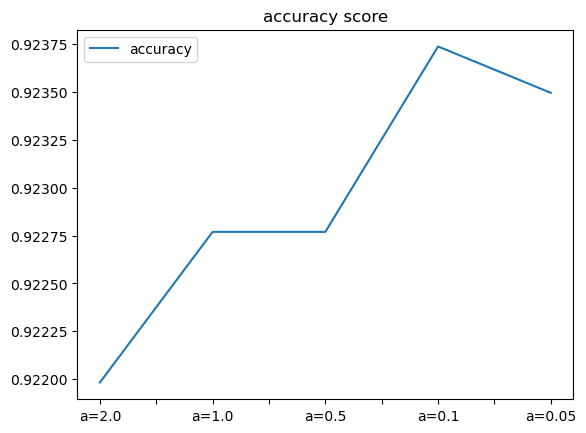

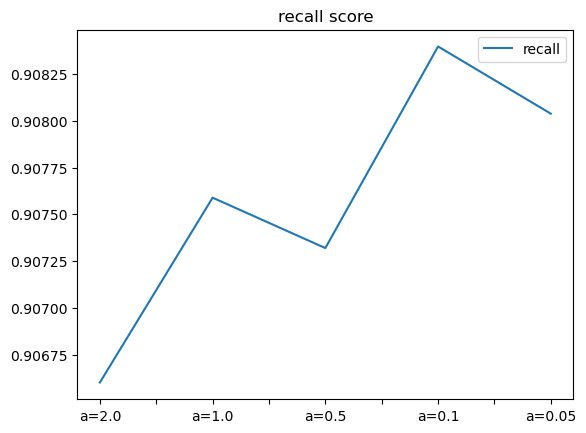

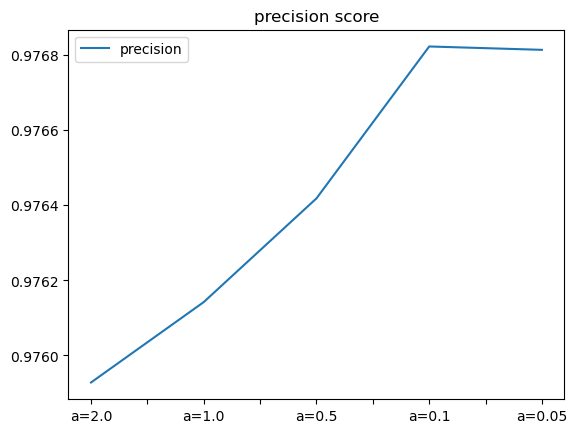

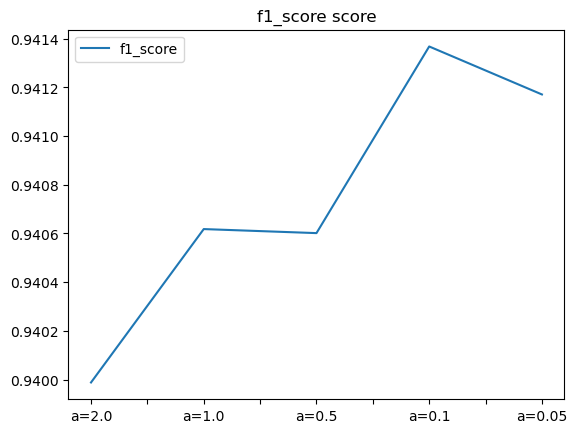

In [77]:
# plot the metrics
plot('accuracy')
plot('recall')
plot('precision')
plot('f1_score')

Based on the graphs for the metrics, all of which showed a positive increase on the scores except for when lambda = 0.1. The accuracy, recall, precision, and f1 scores when lambda = 0.1 is higher than that of lambda = 0.05.

#### Q4: Recommendations to improve the model 

To further improve the model in determining whether an email message is spam or not, it would be worth noting to classify those emails that aren't spam since these messages are more important to avoid deleting. With this, we could further improve the model by decreasing the value of classifying non-spam messages as spam which means improving the accuracy rate of the recall score. Based on the results we have garnered previously, we can try to implement the model using the words that occur at least 50 times that also includes stop words to determine if it would give us a better score in classifying whether an email is spam or not. 